In [1]:
# Pouya Ghaemmaghami
# coding: utf-8

# In[89]:


# import necessary packages:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
import math
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
#import pandas_datareader.data as web
from scipy import stats
import helpers as hp

/Users/nataliabielczyk/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load the fMRI data:
subject_label   = 100307
day_num         = 1
fmri_path       = '/Users/nataliabielczyk/Desktop/variousprojects/Brainhack_networks/BrainhackNetworks_indicators_restingstate-master/datasets/fMRI/'
df              = pd.read_csv(fmri_path + '/day' + str(day_num) + '/' + str(subject_label) + '.csv',header=None)
data            = df.values
Nvars           = data.shape[1]
labels_Glasser  = pd.read_csv(fmri_path + 'labels_Glasser.csv',header=None)[0].tolist()
df.columns      = labels_Glasser
TR              = 0.72 #[s]

In [3]:
print labels_Glasser

['V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', '4', '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'A1', 'PSL', 'SFL', 'PCV', 'STV', '7Pm', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '6ma', '7Am', '7PI', '7PC', 'LIPv', 'VIP', 'MIP', '1', '2', '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', '44', '45', '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-46v', '46', 'a9-46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', '43', 'OP4', 'OP1', 'OP2-3', '52', 'RI', 'PFcm', 'Pol2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'Pft', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSda', 'STSdp', 'STSvp', 'TGd', 'TE1a', 'TE1p', 'TE2a', 'TF', 'TE2p', 'PHT', 'PH', 'TPOJ1', '

In [4]:
# define the indicators:
def moving_average(x,N): 
    """ return moving average from last N samples: """ 
    SMA = 0
    for i in range(N):
        SMA = SMA + (1/N)*x[-i-1]
    return SMA

def exponential_weighted_moving_average(x,N,alpha): 
    """ return exponential weighted moving average from last N samples: """ 
    EWMA = 0
    s = [x[-1]]
    for i in range(N):
        if i == 0:
            s_i = x[-1]
        else:
            s_i = alpha*x[-i-1] + (1 - alpha)*s[i-1]
        EWMA = EWMA + (1/N)*s_i
        s.append(s_i)
    return EWMA

def relative_strength_index(x,N,alpha):
    """ return relative strength index from the last N samples: """
    ups = np.zeros((N,1))
    downs = np.zeros((N,1))
    for ind in range(N):
        if x[-1-ind] > x[-1-ind-1]:
            ups[ind,0] = x[-1-ind] - x[-1-ind-1]
        if x[-1-ind] < x[-1-ind-1]:
            downs[ind,0] = x[-1-ind-1] - x[-1-ind]
    
    EWMA_ups = 0
    s = [ups[-1]]
    for i in range(N):
        if i == 0:
            s_i = s[-1]
        else:
            s_i = alpha*ups[-i-1] + (1 - alpha)*s[i-1]
        EWMA_ups = EWMA_ups + (1/N)*s_i
        s.append(s_i)
        
    EWMA_downs = 0
    s = [downs[-1]]
    for i in range(N):
        if i == 0:
            s_i = downs[-1]
        else:
            s_i = alpha*downs[-i-1] + (1 - alpha)*s[i-1]
        EWMA_downs = EWMA_downs + (1/N)*s_i
        s.append(s_i)
    
    RS = EWMA_ups/EWMA_downs
    RSI = 100 - (100/(1 + RS))
    return RSI

def Bollinger_bands(x,N,alpha,K):
    """ return Bollinger bands: """ 
    # SMA = 0
    # for i in range(N):
    #    SMA = SMA + (1/N)*x[-i-1]
    SMA = np.mean(x[-N:-1])   
    upper_band = SMA + K*np.std(x[-N:-1])   
    lower_band = SMA - K*np.std(x[-N:-1])   
    return SMA, upper_band, lower_band

In [5]:
# select one time series:
ROI_number = 0
x = data[:,ROI_number]
ROI_name = labels_Glasser[ROI_number]
N = len(x)

In [6]:
# calculate the indicators:
# simple moving average:
N_SMA = 14
SMAvec = np.zeros((N - N_SMA,1))
for ind in range(len(SMAvec)):
    SMAvec[ind] = moving_average(x[:-1-ind],N_SMA)
    
# exponential weighted moving average:    
N_EWMA = 14
alpha = 0.2
EWMAvec = np.zeros((N - N_EWMA,1))
for ind in range(len(EWMAvec)):
    EWMAvec[ind] = exponential_weighted_moving_average(x[:-1-ind],N_SMA,alpha)

# MACD:
alpha = 0.2
N_EWMA1 = 12
EWMAvec1 = np.zeros((N - N_EWMA1,1))
for ind in range(len(EWMAvec1)):
    EWMAvec1[ind] = exponential_weighted_moving_average(x[:-1-ind],N_EWMA1,alpha)
N_EWMA2 = 26
EWMAvec2 = np.zeros((N - N_EWMA2,1))
for ind in range(len(EWMAvec2)):
    EWMAvec2[ind] = exponential_weighted_moving_average(x[:-1-ind],N_EWMA2,alpha)
    
# RSI:
alpha = 0.2
N_RSI = 14
RSIvec = np.zeros((N - N_RSI - 1,1))
for ind in range(len(RSIvec)):
    RSIvec[ind] = relative_strength_index(x[:-1-ind],N_RSI,alpha)
    
# Bollinger bands:
K = 1.0
alpha = 0.2
N_BOLL = 14
BOLLvec_ma = np.zeros((N - N_BOLL,1))
BOLLvec_upper = np.zeros((N - N_BOLL,1))
BOLLvec_lower = np.zeros((N - N_BOLL,1))
for ind in range(len(BOLLvec_ma)):
    Boll = Bollinger_bands(x[:-1-ind],N_BOLL,alpha,K)
    BOLLvec_ma[ind] = Boll[0]
    BOLLvec_upper[ind] = Boll[1]
    BOLLvec_lower[ind] = Boll[2]

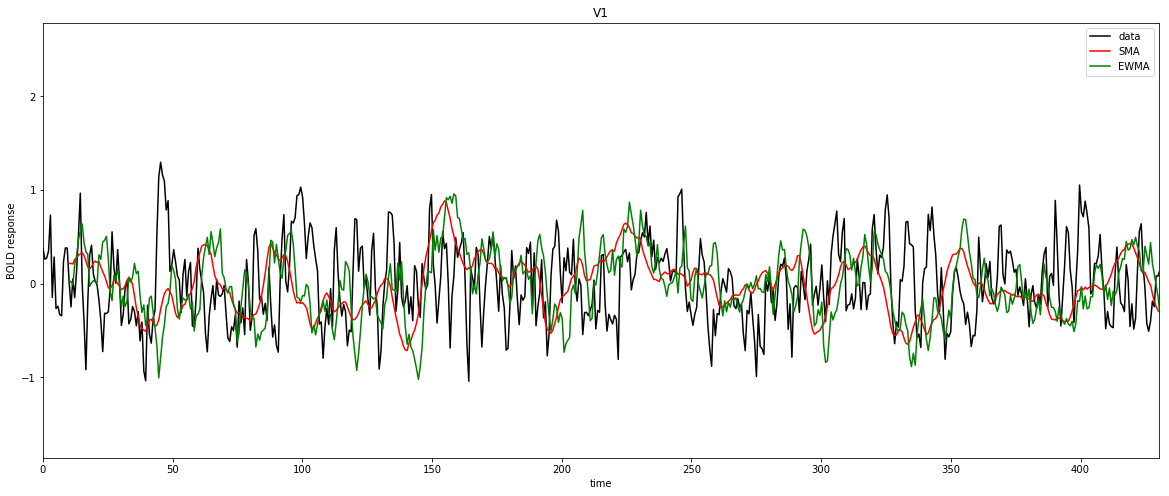

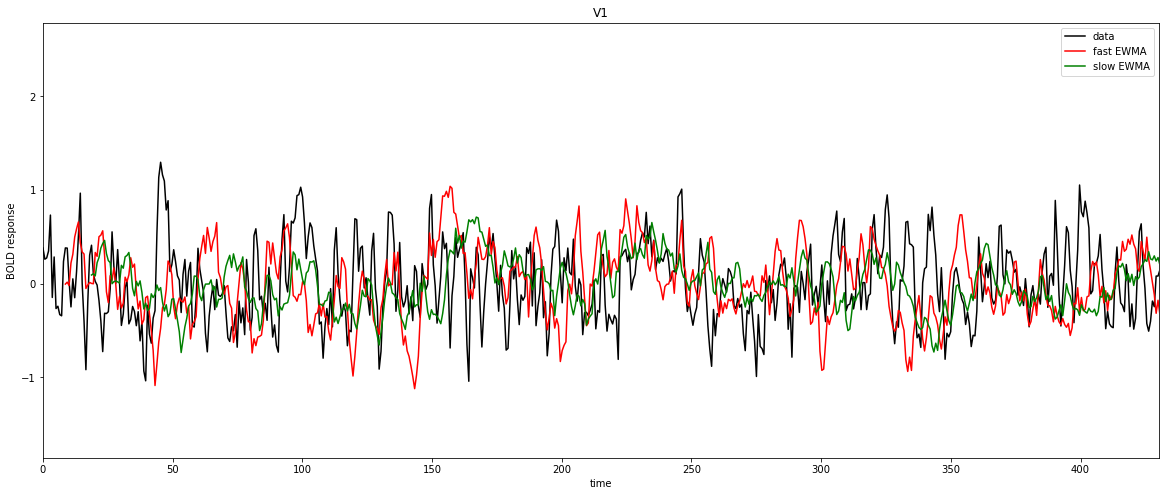

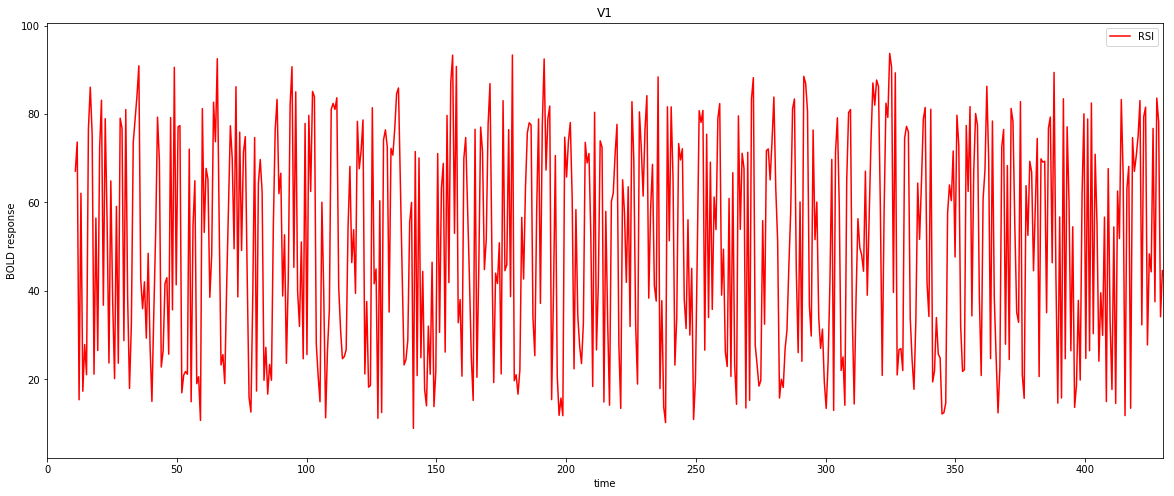

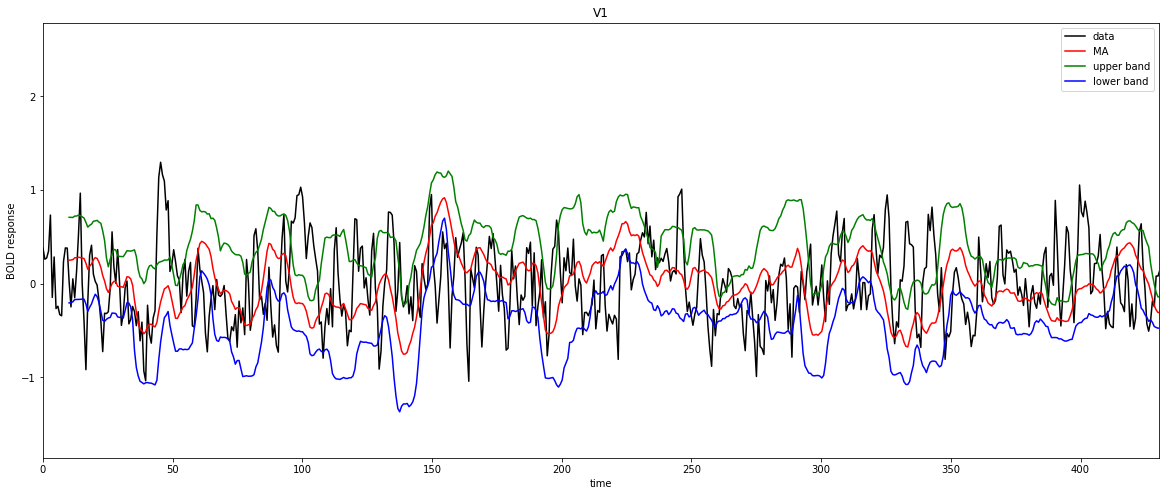

In [7]:
# plot simple and exponential moving average:
plt.figure(figsize=(20,8))
plt.plot(np.arange(N)*TR, x, color='k', label='data')
plt.plot(np.arange(N)[N_SMA:]*TR, SMAvec, color='r', label='SMA')
plt.plot(np.arange(N)[N_EWMA:]*TR, EWMAvec, color='g', label='EWMA')
plt.legend()
plt.xlabel('time')
plt.ylabel('BOLD response')
plt.xlim([0, N*TR*0.25]) #zoom inot first 25% of the chart
plt.title(ROI_name)
plt.show()

# plot MACD:
plt.figure(figsize=(20,8))
plt.plot(np.arange(N)*TR, x, color='k', label='data')
plt.plot(np.arange(N)[N_EWMA1:]*TR, EWMAvec1, color='r', label='fast EWMA')
plt.plot(np.arange(N)[N_EWMA2:]*TR, EWMAvec2, color='g', label='slow EWMA')
plt.legend()
plt.xlabel('time')
plt.ylabel('BOLD response')
plt.xlim([0, N*TR*0.25]) #zoom inot first 25% of the chart
plt.title(ROI_name)
plt.show()

# plot RSI:
plt.figure(figsize=(20,8))
#plt.plot(np.arange(N)*TR, x, color='k', label='data')
plt.plot(np.arange(N)[N_RSI+1:]*TR, RSIvec, color='r', label='RSI')
plt.legend()
plt.xlabel('time')
plt.ylabel('BOLD response')
plt.xlim([0, N*TR*0.25]) #zoom inot first 25% of the chart
plt.title(ROI_name)
plt.show()

# plot Bollinger bands:
plt.figure(figsize=(20,8))
plt.plot(np.arange(N)*TR, x, color='k', label='data')
plt.plot(np.arange(N)[N_BOLL:]*TR, BOLLvec_ma, color='r', label='MA')
plt.plot(np.arange(N)[N_BOLL:]*TR, BOLLvec_upper, color='g', label='upper band')
plt.plot(np.arange(N)[N_BOLL:]*TR, BOLLvec_lower, color='b', label='lower band')
plt.legend()
plt.xlabel('time')
plt.ylabel('BOLD response')
plt.xlim([0, N*TR*0.25]) #zoom inot first 25% of the chart
plt.title(ROI_name)
plt.show()

In [36]:
# In[Data Preperation]
# fill in the 4 parameters:
seq_len             = 22 # the number of past values to predict the future value
future_seq_len      = 10 # the number of future values to predict
predictor_variables = ['V1','V2'] # choose predictor variables
name_target         = 'V2' # choose which variable you want to predict

sequence_length     = seq_len + future_seq_len 
index_target        = predictor_variables.index(name_target)
data                = df.loc[:,predictor_variables].as_matrix() 
nb_features         = data.shape[1]

# chop data into segments:
result = []
for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
    result.append(data[index: index + sequence_length]) # index : index + 22days
result = np.array(result)

# remove the midline (switching from LR to RL encoding):
mid = int(result.shape[0]/2)
result = np.delete(result, range(mid-seq_len, mid+seq_len), axis=0)

# split adta into training and testing set:
row = round(0.9 * result.shape[0]) 
X_train = result[:int(row),:-future_seq_len,:] 
y_train = result[:int(row),-future_seq_len:,index_target]  # index_target was =-1 before

X_test = result[int(row):,:-future_seq_len,:]
y_test = result[int(row):,-future_seq_len:,index_target] 

In [9]:
# compute autocorrelations in the target node, in order to establish the baseline for prediction:
nsteps_max = future_seq_len # maximum number of steps ahead to make a prediction
def autocorr(x, t=1):
    a = np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))
    return a
data_target = df.loc[:,name_target].as_matrix()

# shorten data_target to first half of the data in order to avoid the switching from LR to RL encoding problem:
data_target = data_target[:int(round(len(data_target)/2))]

baselines = np.zeros((nsteps_max,1))
for ind in range(nsteps_max):
    baselines[ind,0] = autocorr(data_target, t=ind+1)[0,1]

In [10]:
print result.shape

(2314, 32, 2)


In [11]:
print y_test.shape

(231, 10)


In [12]:
print X_test.shape
print X_train.shape

(231, 22, 2)
(2083, 22, 2)


In [13]:
# In[Model Building]
d = 0.2
shape = [nb_features, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, future_seq_len]

model = []
model = Sequential()
model.add(LSTM(units=neurons[0], return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(d))
model.add(LSTM(neurons[1], return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(d))
model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
#model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')
#model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           67072     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 203,114
Trainable params: 203,114
Non-trainable params: 0
_________________________________________________________________


In [14]:
# In[Model Fitting]
model.fit(X_train, y_train, batch_size=512, epochs=50, validation_split=0.1, verbose=1)

Train on 1874 samples, validate on 209 samples
Epoch 1/50
1874/1874 [==============================] - 21s 11ms/step - loss: 0.1555 - val_loss: 0.1859
Epoch 2/50
1874/1874 [==============================] - 6s 3ms/step - loss: 0.1531 - val_loss: 0.1862
Epoch 3/50
1874/1874 [==============================] - 7s 4ms/step - loss: 0.1506 - val_loss: 0.1884
Epoch 4/50
1874/1874 [==============================] - 7s 4ms/step - loss: 0.1504 - val_loss: 0.1875
Epoch 5/50
1874/1874 [==============================] - 6s 3ms/step - loss: 0.1493 - val_loss: 0.1919
Epoch 6/50
1874/1874 [==============================] - 7s 4ms/step - loss: 0.1482 - val_loss: 0.1913
Epoch 7/50
1874/1874 [==============================] - 7s 4ms/step - loss: 0.1477 - val_loss: 0.1906
Epoch 8/50
1874/1874 [==============================] - 7s 4ms/step - loss: 0.1470 - val_loss: 0.1967
Epoch 9/50
1874/1874 [==============================] - 6s 3ms/step - loss: 0.1459 - val_loss: 0.1934
Epoch 10/50
1874/1874 [==========

In [15]:
# In[Results]
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))


from scipy import stats
from scipy.stats.stats import pearsonr

prediction = model.predict(X_test)
prediction = np.squeeze(prediction)

Train Score: 0.13637 MSE (0.37 RMSE)
Test Score: 0.21297 MSE (0.46 RMSE)


In [16]:
# summarize the results from deep learning:
if future_seq_len == 1:
    results_deeplearning = np.zeros((future_seq_len,1))
    for ind in range(future_seq_len):
        results_deeplearning[ind,0] = pearsonr(prediction[:],np.squeeze(y_test[:]))[0]
    print results_deeplearning
else:
    results_deeplearning = np.zeros((future_seq_len,1))
    for ind in range(future_seq_len):
        results_deeplearning[ind,0] = pearsonr(prediction[:,ind],np.squeeze(y_test[:,ind]))[0]
    print results_deeplearning

[[0.82023978]
 [0.66305643]
 [0.47643096]
 [0.32070958]
 [0.25526107]
 [0.19104312]
 [0.20187645]
 [0.20330522]
 [0.21342272]
 [0.2705795 ]]


In [17]:
# compare with baseline:
print baselines

[[ 0.75313134]
 [ 0.51559211]
 [ 0.31345645]
 [ 0.2005305 ]
 [ 0.11339312]
 [ 0.05606893]
 [ 0.02904786]
 [ 0.03077386]
 [ 0.00763259]
 [-0.01135883]]


In [20]:
# run autoregressive model:

In [37]:
from pandas import Series
from matplotlib import pyplot

import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

In [40]:
# chop data into segments in a new way:
# make 100 samples longer segments to help fitting multivariate ARs
extra_samples   = 100
total_seq_len   = seq_len + extra_samples
result = []
for index in range(len(data) - total_seq_len): # maxmimum date = lastest date - sequence length
    result.append(data[index: index + total_seq_len]) # index : index + 22days
result = np.array(result)

# remove the midline (switching from LR to RL encoding):
mid = int(result.shape[0]/2)
result = np.delete(result, range(mid-total_seq_len, mid+total_seq_len), axis=0)

# split data into training and testing set:
X_train = result[:,:-future_seq_len,:] 
y_train = result[:,-future_seq_len:,index_target] 
num_of_segments = X_train.shape[0]
print num_of_segments

2024


In [48]:
var_predictions = np.zeros((num_of_segments,future_seq_len))

for ind in range(num_of_segments):
    model = VAR(np.squeeze(X_train[ind,:,:]))
    results = model.fit(seq_len)
    
    lag_order = results.k_ar
    forecast_segment = results.forecast(X_train[ind,:,:], future_seq_len)
    var_predictions[ind,:] = forecast_segment[:,index_target]

print var_predictions[0:1,:]

[[-0.68137612 -0.62296333 -0.55607567 -0.53018075 -0.50418911  0.10709538
   0.07832904  0.19832379 -0.38991115 -0.09851793]]


In [52]:
results_var = np.zeros((future_seq_len,1))
for ind in range(future_seq_len):
    results_var[ind,0] = pearsonr(var_predictions[:,ind],np.squeeze(y_train[:,ind]))[0]

In [53]:
print results_var

[[ 0.64981609]
 [ 0.37283353]
 [ 0.16456213]
 [ 0.05022307]
 [-0.01291469]
 [-0.05845408]
 [-0.07789633]
 [-0.07752869]
 [-0.07412021]
 [-0.06911294]]


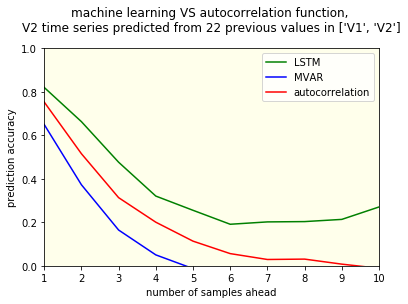

In [54]:
# plot the results:
fig = plt.figure()

ax = plt.gca()
ax.set_facecolor((1,1,235/255))

x = np.arange(future_seq_len)
labels = np.ndarray.tolist(x + 1)
plt.xticks(x, labels)
plt.plot(x, results_deeplearning[:,0], 'g', label = 'LSTM')
plt.plot(x, results_var[:,0], 'b', label = 'MVAR')
plt.plot(x, baselines[:,0], 'r', label = 'autocorrelation')
plt.xlim([0,future_seq_len - 1])
plt.ylim([0,1])
plt.xlabel('number of samples ahead')
plt.ylabel('prediction accuracy')

plt.title('machine learning VS autocorrelation function, ' + '\n' + name_target  + \
          ' time series predicted from ' + str(seq_len) + ' previous values in ' + str(predictor_variables), y=1.05)
plt.legend()
plt.show()

In [19]:
# save the plot:
filename = 'MLvsAUTOCORR_target' + name_target + '_predictors' + str(predictor_variables) + \
'_subject' + str(subject_label) + '_day' + str(day_num)


folder_output = '/Users/nataliabielczyk/Desktop/variousprojects/Brainhack_networks/BrainhackNetworks_indicators_restingstate-master/results/'
fname = folder_output + filename

dpis = [300, 600]
formats = ['jpg', 'png', 'pdf']

hp.savef(fig, fname, dpis, formats)